In [1]:
import os
# For Colab/Google Drive integration:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/FinRL/final')  # Change to your project folder in Drive

Mounted at /content/drive


In [7]:
# -*- coding: utf-8 -*-
"""4_1_rnn_trainer.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/12PXz-1dQ4HxtfU1-2_lTEXeXlSqIjcvx
"""

import os
# For Colab/Google Drive integration:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/FinRL/final')  # Change to your project folder in Drive

import os
import time
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from typing import Optional, Tuple
import matplotlib.pyplot as plt

# Constants
WINDOW = 10
PERIOD = 10

# Label generation functions (from seq_data.py)
def _normal_moving_average(ary, win_size=5):
    avg = ary.copy()
    avg[win_size - 1 :] = np.convolve(ary, np.ones(win_size) / win_size, mode="valid")
    return avg

def seq_to_label(ary, win_sizes=(10, 20, 40, 80, 160), if_print=False):
    labels = []
    win_sizes = np.array(win_sizes)
    offsets = np.cumsum(win_sizes)

    px_avg_0 = _normal_moving_average(ary, win_size=5)
    for win_size, offset in zip(win_sizes, offsets):
        px_avg_i = _normal_moving_average(ary, win_size=win_size)

        px_diff = px_avg_i[offset:] - px_avg_0[:-offset]

        # less_than
        lt_ary = np.quantile(px_diff, q=(0.01, 0.02, 0.04, 0.07, 0.10, 0.15, 0.20, 0.30, 0.40), axis=0)
        lt_ary = np.less(px_diff[:, None], lt_ary[None, :]).astype(np.float32).mean(axis=1)

        # greater_than
        gt_ary = np.quantile(px_diff, q=(0.60, 0.70, 0.80, 0.85, 0.90, 0.93, 0.96, 0.98, 0.99), axis=0)
        gt_ary = np.greater(px_diff[:, None], gt_ary[None, :]).astype(np.float32).mean(axis=1)

        # merge
        label = gt_ary - lt_ary
        labels.append(label)

        """print"""
        if if_print:
            unique_values, counts = np.unique(label, return_counts=True)
            rates = np.round(counts / label.shape[0], 2)
            print(f"win_size {win_size:6} | unique_values {str(unique_values):32}  rate {rates}")

    min_length = min([label.shape[0] for label in labels])
    labels = np.concatenate([label[:min_length, None] for label in labels], axis=1)
    return labels

# Enhanced Neural Network Architecture
class NnSeqBnMLP(nn.Module):
    def __init__(self, dims, if_inp_norm=False, if_layer_norm=True, activation=None, dropout=0.1):
        super(NnSeqBnMLP, self).__init__()

        mlp_list = []
        if if_inp_norm:
            mlp_list.append(nn.BatchNorm1d(dims[0], momentum=0.9))

        mlp_list.append(nn.Linear(dims[0], dims[1]))
        for i in range(1, len(dims) - 1):
            mlp_list.append(nn.GELU())
            mlp_list.append(nn.Dropout(dropout))
            mlp_list.append(nn.LayerNorm(dims[i])) if if_layer_norm else None
            mlp_list.append(nn.Linear(dims[i], dims[i + 1]))

        if activation is not None:
            mlp_list.append(activation)

        self.mlp = nn.Sequential(*mlp_list)

        if activation is not None:
            layer_init_with_orthogonal(self.mlp[-2], std=0.1)
        else:
            layer_init_with_orthogonal(self.mlp[-1], std=0.1)

    def forward(self, seq):
        d0, d1, d2 = seq.shape
        inp = seq.reshape(d0 * d1, -1)
        out = self.mlp(inp)
        return out.reshape(d0, d1, -1)

    def reset_parameters(self, std=1.0, bias_const=1e-6):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                th.nn.init.orthogonal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, bias_const)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, std)
                nn.init.constant_(module.bias, 0)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()

        # Linear transformations and reshape
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = th.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = th.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention to values
        context = th.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        # Output projection and residual connection
        output = self.w_o(context)
        output = self.layer_norm(output + x)

        return output

class DeepRNNBlock(nn.Module):
    def __init__(self, hidden_dim, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers,
                           dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Projection layer to combine LSTM and GRU outputs
        self.combine_projection = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x, hidden_states=None):
        lstm_hidden, gru_hidden = (None, None) if hidden_states is None else hidden_states

        # LSTM branch
        lstm_out, lstm_hidden = self.lstm(x, lstm_hidden)
        lstm_out = self.layer_norm1(lstm_out + x)  # Residual connection

        # GRU branch
        gru_out, gru_hidden = self.gru(x, gru_hidden)
        gru_out = self.layer_norm2(gru_out + x)  # Residual connection

        # Combine outputs and project back to original dimension
        combined = th.cat([lstm_out, gru_out], dim=-1)
        combined = self.combine_projection(combined)

        return combined, (lstm_hidden, gru_hidden)

class EnhancedRnnRegNet(nn.Module):
    def __init__(self, inp_dim, mid_dim, out_dim, num_layers, num_blocks=3, num_heads=8, dropout=0.1):
        super(EnhancedRnnRegNet, self).__init__()

        self.num_blocks = num_blocks
        self.mid_dim = mid_dim

        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(inp_dim, mid_dim),
            nn.LayerNorm(mid_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Deep RNN blocks with residual connections
        self.rnn_blocks = nn.ModuleList([
            DeepRNNBlock(mid_dim, num_layers, dropout) for _ in range(num_blocks)
        ])

        # Attention mechanism (now works with mid_dim since we project back)
        self.attention = MultiHeadAttention(mid_dim, num_heads, dropout)

        # Output processing
        self.output_mlp = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.LayerNorm(mid_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mid_dim, mid_dim // 2),
            nn.LayerNorm(mid_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mid_dim // 2, out_dim),
            nn.Tanh()
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            th.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)
        elif isinstance(module, nn.GRU):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)

    def forward(self, inp, hid=None):
        batch_size, seq_len, _ = inp.shape

        # Input projection
        x = self.input_projection(inp)

        # Process through RNN blocks with residual connections
        hidden_states = hid
        for i, block in enumerate(self.rnn_blocks):
            x, hidden_states = block(x, hidden_states)

            # Add residual connection between blocks
            if i > 0:
                x = x + residual
            residual = x

        # Apply attention
        x = self.attention(x)

        # Output processing
        out = self.output_mlp(x)

        return out, hidden_states

    @staticmethod
    def get_obj_value(criterion, out: th.Tensor, lab: th.Tensor, wup_dim: int) -> th.Tensor:
        obj = criterion(out, lab)[wup_dim:, :, :]
        return obj

# Keep the original RnnRegNet for backward compatibility
class RnnRegNet(nn.Module):
    def __init__(self, inp_dim, mid_dim, out_dim, num_layers):
        super(RnnRegNet, self).__init__()
        self.rnn1 = nn.LSTM(mid_dim, mid_dim, num_layers=num_layers)
        self.mlp1 = NnSeqBnMLP(
            dims=(mid_dim, mid_dim, mid_dim), if_layer_norm=False, activation=nn.GELU()
        )

        self.rnn2 = nn.GRU(mid_dim, mid_dim, num_layers=num_layers)
        self.mlp2 = NnSeqBnMLP(
            dims=(mid_dim, mid_dim, mid_dim), if_layer_norm=False, activation=nn.GELU()
        )

        self.mlp_inp = NnSeqBnMLP(
            dims=(inp_dim, mid_dim, mid_dim), if_layer_norm=False, activation=nn.GELU()
        )
        self.mlp_out = NnSeqBnMLP(
            dims=(mid_dim * 2, mid_dim * 2, out_dim),
            if_layer_norm=False,
            activation=nn.Tanh(),
        )

    def forward(self, inp, hid=None):
        hid1, hid2 = (None, None) if hid is None else hid
        inp = self.mlp_inp(inp)

        rnn1, hid1 = self.rnn1(inp, hid1)
        tmp1 = self.mlp1(rnn1)

        rnn2, hid2 = self.rnn2(inp, hid2)
        tmp2 = self.mlp2(rnn2)

        tmp = th.concat((tmp1, tmp2), dim=2)
        out = self.mlp_out(tmp)
        return out, (hid1, hid2)

    @staticmethod
    def get_obj_value(criterion, out: th.Tensor, lab: th.Tensor, wup_dim: int) -> th.Tensor:
        obj = criterion(out, lab)[wup_dim:, :, :]
        return obj

def layer_init_with_orthogonal(layer, std=1.0, bias_const=1e-6):
    th.nn.init.orthogonal_(layer.weight, std)
    th.nn.init.constant_(layer.bias, bias_const)

# Enhanced Data Loading and Training Functions
class SeqData:
    def __init__(self, train_input_path, valid_input_path, test_input_path, label_path,
                 valid_label_path=None, test_label_path=None):
        self.train_input_path = train_input_path
        self.valid_input_path = valid_input_path
        self.test_input_path = test_input_path
        self.label_path = label_path
        self.valid_label_path = valid_label_path
        self.test_label_path = test_label_path

        '''Load pre-split data'''
        print("Loading pre-split data...")

        # Load training data
        self.train_input_seq = np.load(train_input_path)
        self.train_input_seq = np.nan_to_num(self.train_input_seq, nan=0.0, neginf=0.0, posinf=0.0)
        self.train_input_seq = th.tensor(self.train_input_seq, dtype=th.float32)
        assert th.isnan(self.train_input_seq).sum() == 0

        # Load validation data
        self.valid_input_seq = np.load(valid_input_path)
        self.valid_input_seq = np.nan_to_num(self.valid_input_seq, nan=0.0, neginf=0.0, posinf=0.0)
        self.valid_input_seq = th.tensor(self.valid_input_seq, dtype=th.float32)
        assert th.isnan(self.valid_input_seq).sum() == 0

        # Load test data
        self.test_input_seq = np.load(test_input_path)
        self.test_input_seq = np.nan_to_num(self.test_input_seq, nan=0.0, neginf=0.0, posinf=0.0)
        self.test_input_seq = th.tensor(self.test_input_seq, dtype=th.float32)
        assert th.isnan(self.test_input_seq).sum() == 0

        # Load labels
        label_seq = np.load(label_path)
        label_seq = th.tensor(label_seq, dtype=th.float32)
        assert th.isnan(label_seq).sum() == 0

        # Get dimensions
        self.input_dim = self.train_input_seq.shape[1]
        self.label_dim = label_seq.shape[1]

        # Get sequence lengths
        self.train_seq_len = self.train_input_seq.shape[0]
        self.valid_seq_len = self.valid_input_seq.shape[0]
        self.test_seq_len = self.test_input_seq.shape[0]

        # Handle training labels
        if label_seq.shape[0] >= self.train_seq_len:
            self.train_label_seq = label_seq[:self.train_seq_len]
        else:
            if label_seq.shape[0] < self.train_seq_len:
                print(f"Warning: Labels shorter than training data. Padding with zeros.")
                padding = th.zeros(self.train_seq_len - label_seq.shape[0], label_seq.shape[1])
                self.train_label_seq = th.cat([label_seq, padding], dim=0)
            else:
                self.train_label_seq = label_seq[:self.train_seq_len]

        # Handle validation labels
        if valid_label_path and os.path.exists(valid_label_path):
            print(f"Loading validation labels from: {valid_label_path}")
            valid_labels = np.load(valid_label_path)
            valid_labels = th.tensor(valid_labels, dtype=th.float32)
            if valid_labels.shape[0] >= self.valid_seq_len:
                self.valid_label_seq = valid_labels[:self.valid_seq_len]
            else:
                # Pad if shorter
                padding = th.zeros(self.valid_seq_len - valid_labels.shape[0], valid_labels.shape[1])
                self.valid_label_seq = th.cat([valid_labels, padding], dim=0)
        else:
            # Create validation labels from training labels (assuming same structure)
            print("Creating validation labels from training labels...")
            if self.train_label_seq.shape[0] >= self.valid_seq_len:
                self.valid_label_seq = self.train_label_seq[:self.valid_seq_len]
            else:
                # If training labels are shorter, pad
                padding = th.zeros(self.valid_seq_len - self.train_label_seq.shape[0], self.train_label_seq.shape[1])
                self.valid_label_seq = th.cat([self.train_label_seq, padding], dim=0)

        # Handle test labels
        if test_label_path and os.path.exists(test_label_path):
            print(f"Loading test labels from: {test_label_path}")
            test_labels = np.load(test_label_path)
            test_labels = th.tensor(test_labels, dtype=th.float32)
            if test_labels.shape[0] >= self.test_seq_len:
                self.test_label_seq = test_labels[:self.test_seq_len]
            else:
                # Pad if shorter
                padding = th.zeros(self.test_seq_len - test_labels.shape[0], test_labels.shape[1])
                self.test_label_seq = th.cat([test_labels, padding], dim=0)
        else:
            # Create test labels from training labels (assuming same structure)
            print("Creating test labels from training labels...")
            if self.train_label_seq.shape[0] >= self.test_seq_len:
                self.test_label_seq = self.train_label_seq[:self.test_seq_len]
            else:
                # If training labels are shorter, pad
                padding = th.zeros(self.test_seq_len - self.train_label_seq.shape[0], self.train_label_seq.shape[1])
                self.test_label_seq = th.cat([self.train_label_seq, padding], dim=0)

        print(f"Data loaded - Train: {self.train_seq_len}, Valid: {self.valid_seq_len}, Test: {self.test_seq_len}")
        print(f"Input dim: {self.input_dim}, Label dim: {self.label_dim}")
        print(f"Label shapes - Train: {self.train_label_seq.shape}, Valid: {self.valid_label_seq.shape}, Test: {self.test_label_seq.shape}")

    def sample_for_train(self, batch_size: int = 32, seq_len: int = 4096, device: th.device = th.device('cpu')):
        # If sequence length is larger than available data, reduce it
        if seq_len > self.train_seq_len:
            seq_len = max(16, self.train_seq_len // 2)
            print(f"Sequence length too large for dataset. Reduced to {seq_len}")

        # Ensure we don't exceed the data bounds
        max_start = self.train_seq_len - seq_len
        if max_start <= 0:
            # For very small datasets, use the entire sequence
            i0s = np.zeros(batch_size, dtype=int)
            seq_len = self.train_seq_len  # Use all available data
        else:
            # Adjust sampling range for small datasets
            min_start = min(1024, self.train_seq_len // 4)  # Use smaller minimum for small datasets
            max_start = max(min_start + 1, self.train_seq_len - seq_len)

            if max_start <= min_start:
                # For very small datasets, use the entire sequence
                i0s = np.zeros(batch_size, dtype=int)
                seq_len = self.train_seq_len  # Use all available data
            else:
                i0s = np.random.randint(min_start, max_start, size=batch_size)

        # Create indices that stay within bounds
        ids = np.arange(seq_len)[None, :].repeat(batch_size, axis=0) + i0s[:, None]

        # Ensure all indices are within bounds
        ids = np.clip(ids, 0, self.train_seq_len - 1)

        input_ary = self.train_input_seq[ids, :].permute(1, 0, 2).to(device)
        label_seq = self.train_label_seq[ids, :].permute(1, 0, 2).to(device)

        # Data augmentation: Add noise to input features
        # Always apply small noise for regularization (can be controlled by training function)
        noise_std = 0.01  # Small noise for regularization
        noise = th.randn_like(input_ary) * noise_std
        input_ary = input_ary + noise

        return input_ary, label_seq

    def get_validation_batch(self, batch_size: int, seq_len: int, device: th.device):
        """Get actual validation data batch"""
        if seq_len > self.valid_seq_len:
            seq_len = self.valid_seq_len

        # Use sequential validation data
        start_idx = 0
        end_idx = min(seq_len, self.valid_seq_len)

        inp = self.valid_input_seq[start_idx:end_idx].unsqueeze(0).to(device)  # Add batch dimension
        lab = self.valid_label_seq[start_idx:end_idx].unsqueeze(0).to(device)

        return inp, lab

    def get_test_batch(self, batch_size: int, seq_len: int, device: th.device):
        """Get actual test data batch"""
        if seq_len > self.test_seq_len:
            seq_len = self.test_seq_len

        # Use sequential test data
        start_idx = 0
        end_idx = min(seq_len, self.test_seq_len)

        inp = self.test_input_seq[start_idx:end_idx].unsqueeze(0).to(device)  # Add batch dimension
        lab = self.test_label_seq[start_idx:end_idx].unsqueeze(0).to(device)

        return inp, lab

def _update_network(optimizer, obj, clip_grad_norm):
    optimizer.zero_grad()
    obj.backward()
    clip_grad_norm_(parameters=optimizer.param_groups[0]["params"], max_norm=clip_grad_norm)
    optimizer.step()

# Label smoothing function
def smooth_labels(labels, smoothing=0.1):
    """Apply label smoothing to reduce overfitting"""
    if smoothing > 0:
        # Add small random noise to labels
        noise = th.randn_like(labels) * smoothing * 0.1
        labels = labels + noise
        # Clip to reasonable range
        labels = th.clamp(labels, -1.0, 1.0)
    return labels

# Enhanced Training Function with Learning Rate Scheduling and Better Regularization
def train_sequence_model(input_ary_path, label_ary_path, output_dir='./output', gpu_id=0, use_enhanced=True):
    """
    Train the sequence model using alpha101 signals with enhanced architecture

    Args:
        input_ary_path: Path to alpha101 signals (.npy)
        label_ary_path: Path to labels (.npy)
        output_dir: Output directory for model and plots
        gpu_id: GPU ID to use (-1 for CPU)
        use_enhanced: Whether to use the enhanced RNN architecture
    """
    device = th.device(f"cuda:{gpu_id}" if (th.cuda.is_available() and (gpu_id >= 0)) else "cpu")
    print(f"Using device: {device}")

    '''Enhanced Config for training'''
    batch_size = 64      # Reduced for better regularization
    mid_dim = 192        # Reduced from 256 for less complexity
    num_layers = 4       # Reduced from 6 for less complexity
    epoch = 2 ** 10      # Keep same training epochs
    wup_dim = 128        # Keep same warmup
    valid_gap = 32       # More frequent validation (was 64)
    num_patience = 16    # Increased patience for better convergence
    weight_decay = 1e-3  # Increased from 5e-4 for stronger regularization
    learning_rate = 3e-4 # Reduced from 5e-4 for stability
    clip_grad_norm = 1.0 # Keep same gradient clipping
    dropout = 0.35       # Increased from 0.2 for better regularization

    os.makedirs(output_dir, exist_ok=True)

    '''Load data'''
    print("Loading data...")
    seq_data = SeqData(
        train_input_path=f"{os.path.dirname(input_ary_path)}/alpha101_train.npy",
        valid_input_path=f"{os.path.dirname(input_ary_path)}/alpha101_val.npy",
        test_input_path=f"{os.path.dirname(input_ary_path)}/alpha101_test.npy",
        label_path=label_ary_path
    )
    input_dim = seq_data.input_dim
    label_dim = seq_data.label_dim
    print(f"Input dim: {input_dim}, Label dim: {label_dim}")

    '''Model'''
    print("Initializing enhanced model..." if use_enhanced else "Initializing standard model...")
    if use_enhanced:
        net = EnhancedRnnRegNet(
            inp_dim=input_dim,
            mid_dim=mid_dim,
            out_dim=label_dim,
            num_layers=num_layers,
            num_blocks=2,  # Reduced from 4 to 2 for less complexity
            num_heads=6,   # Reduced from 8 to 6 heads
            dropout=dropout
        ).to(device)
    else:
        net = RnnRegNet(inp_dim=input_dim, mid_dim=mid_dim, out_dim=label_dim, num_layers=num_layers).to(device)

    # Enhanced optimizer with better scheduling
    optimizer = th.optim.AdamW(
        net.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # Learning rate scheduler
    scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-6
    )

    # Enhanced loss function with label smoothing
    criterion = th.nn.MSELoss(reduction='none')

    '''Training loop'''
    print("Starting training...")
    seq_len = 2 ** 9  # Increased sequence length
    train_times = int(seq_data.train_seq_len / seq_len / batch_size * epoch)
    print(f"Training for {train_times} steps...")

    # Check if we have enough data for training
    if train_times <= 0:
        print("Not enough data for training. Reducing batch size or sequence length.")
        # Try with smaller batch size
        batch_size = min(batch_size, seq_data.train_seq_len // seq_len)
        if batch_size <= 0:
            # Try with smaller sequence length
            seq_len = seq_len // 2
            batch_size = min(128, seq_data.train_seq_len // seq_len)
            if batch_size <= 0:
                # Try with even smaller sequence length
                seq_len = 64
                batch_size = min(32, seq_data.train_seq_len // seq_len)
                if batch_size <= 0:
                    print("Still not enough data. Skipping training.")
                    return
            print(f"Retrying with seq_len={seq_len}, batch_size={batch_size}")
        else:
            print(f"Retrying with batch_size={batch_size}")

        train_times = int(seq_data.train_seq_len / seq_len / batch_size * epoch)
        print(f"Training for {train_times} steps...")

    # For very small datasets, also reduce the training sequence length
    if seq_data.train_seq_len < 1024:
        print(f"Small dataset detected. Adjusting training sequence length from 1024 to {seq_data.train_seq_len // 2}")
        # This will be handled in the SeqData class, but we need to ensure the data is sufficient
        if seq_data.train_seq_len < seq_len:
            print(f"Dataset too small for sequence length {seq_len}. Reducing to {seq_data.train_seq_len // 2}")
            seq_len = max(32, seq_data.train_seq_len // 2)  # Ensure minimum sequence length
            batch_size = min(batch_size, seq_data.train_seq_len // seq_len)
            train_times = int(seq_data.train_seq_len / seq_len / batch_size * epoch)
            print(f"Adjusted training for {train_times} steps with seq_len={seq_len}, batch_size={batch_size}")

    # Training history
    train_losses = []
    valid_losses = []
    patience = 0
    best_valid_loss = float('inf')
    lr_history = []

    for step_idx in range(train_times):
        th.set_grad_enabled(True)
        net.train()
        inp, lab = seq_data.sample_for_train(batch_size=batch_size, seq_len=seq_len, device=device)

        # Apply label smoothing for regularization
        lab = smooth_labels(lab, smoothing=0.1)

        # Ensure proper input shape for enhanced model
        if use_enhanced and len(inp.shape) == 3:
            inp = inp.permute(1, 0, 2)  # (seq_len, batch, features) -> (batch, seq_len, features)

        out, _ = net(inp)

        # Ensure proper output shape
        if use_enhanced and len(out.shape) == 3:
            out = out.permute(1, 0, 2)  # (batch, seq_len, features) -> (seq_len, batch, features)
        elif use_enhanced and len(out.shape) == 2:
            # Enhanced model output: (seq_len, features)
            out = out.unsqueeze(1)  # Add batch dimension: (seq_len, 1, features)

        seq_len_actual = min(out.shape[0], lab.shape[0])
        obj = net.get_obj_value(criterion=criterion, out=out, lab=lab, wup_dim=wup_dim)
        _update_network(optimizer, obj.mean(), clip_grad_norm)

        train_loss = obj.mean().item()
        train_losses.append(train_loss)

        if step_idx % 10 == 0:  # Print every 10 steps
            current_lr = optimizer.param_groups[0]['lr']
            lr_history.append(current_lr)
            print(f"Step {step_idx}: Train Loss = {train_loss:.6f}, LR = {current_lr:.2e}")

        # Validation
        if step_idx % valid_gap == 0:
            net.eval()
            valid_loss = 0.0
            valid_count = 0

            with th.no_grad():
                # Use actual validation data instead of training data samples
                for seq_i0 in range(0, seq_data.valid_seq_len, seq_len):
                    seq_i1 = min(seq_i0 + seq_len, seq_data.valid_seq_len)
                    inp = seq_data.valid_input_seq[seq_i0:seq_i1].to(device)
                    lab = seq_data.valid_label_seq[seq_i0:seq_i1].to(device)

                    # Ensure proper input shape for enhanced model
                    if use_enhanced:
                        inp = inp.unsqueeze(0)  # Add batch dimension
                        out, _ = net(inp)
                        out = out.squeeze(0)  # Remove batch dimension
                    else:
                        out, _ = net(inp[:, None, :])

                    seq_len_actual = min(out.shape[0], lab.shape[0])

                    # Handle different output dimensions
                    if len(out.shape) == 3:
                        # Enhanced model output: (seq_len, batch, features)
                        out = out[wup_dim:seq_len_actual, :, :]
                        lab = lab[wup_dim:seq_len_actual, :, :]
                    elif len(out.shape) == 2:
                        # Enhanced model output: (seq_len, features)
                        out = out[wup_dim:seq_len_actual, :]
                        lab = lab[wup_dim:seq_len_actual, :]
                        # Add batch dimension for loss calculation
                        out = out.unsqueeze(1)
                        lab = lab.unsqueeze(1)

                    loss = criterion(out, lab)
                    valid_loss += loss.mean().item()
                    valid_count += 1

            # Only calculate validation loss if we have validation data
            if valid_count > 0:
                valid_loss = valid_loss / valid_count
                valid_losses.append(valid_loss)

                # Update learning rate scheduler
                scheduler.step(valid_loss)

                print(f"Step {step_idx:6d} | Train Loss: {train_loss:.6f} | Valid Loss: {valid_loss:.6f} | Patience: {patience}")
            else:
                print(f"Step {step_idx:6d} | Train Loss: {train_loss:.6f} | Valid Loss: N/A | Patience: {patience}")

            # Early stopping with improved strategy
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                patience = 0
                # Save best model
                th.save(net.state_dict(), f'{output_dir}/best_model.pth')
            else:
                patience += 1

            # Additional early stopping: check if validation loss is diverging from training loss
            train_valid_gap = abs(train_loss - valid_loss)
            if train_valid_gap > 0.5:  # If gap is too large, increase patience penalty
                patience += 1
                print(f"Warning: Large train-valid gap ({train_valid_gap:.4f}), increasing patience penalty")

            if patience >= num_patience:
                print(f"Early stopping at step {step_idx}")
                print(f"Best validation loss: {best_valid_loss:.6f}")
                break

    print("Training completed!")

    # Only proceed if we actually trained
    if len(train_losses) == 0:
        print("No training occurred due to insufficient data.")
        return

    # Load best model
    net.load_state_dict(th.load(f'{output_dir}/best_model.pth'))

    # Generate predictions for validation set (as shown in the second image)
    print("Generating predictions...")
    predict_ary = np.empty_like(seq_data.valid_label_seq)
    hid = None

    for seq_i0 in range(0, seq_data.valid_seq_len, seq_len):
        seq_i1 = min(seq_i0 + seq_len, seq_data.valid_seq_len)
        inp = seq_data.valid_input_seq[seq_i0:seq_i1].to(device)

        if use_enhanced:
            inp = inp.unsqueeze(0)  # Add batch dimension
            out, hid = net.forward(inp, hid)
            out = out.squeeze(0)  # Remove batch dimension
        else:
            out, hid = net.forward(inp[:, None, :], hid)

        # Handle different output dimensions
        if len(out.shape) == 3:
            # Enhanced model output: (seq_len, batch, features)
            out = out.squeeze(1)  # Remove batch dimension: (seq_len, features)
        elif len(out.shape) == 2:
            # Enhanced model output: (seq_len, features) - already correct
            pass

        predict_ary[seq_i0:seq_i1] = out.data.cpu().numpy()

    # Save predictions (as shown in the second image)
    predict_path = f'{output_dir}/predictions.npy'
    np.save(predict_path, predict_ary)
    print(f"Predictions saved to: {predict_path}")

    # Enhanced plotting with learning rate history (as shown in the second image)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training curves
    if len(train_losses) > 0:
        ax1.plot(train_losses, label='Train Loss', alpha=0.7, color='blue')
        print(f"Plotted {len(train_losses)} training losses")
    else:
        print("No training losses to plot")

    # Fix validation loss plotting - only plot if we have validation losses
    if valid_losses:
        print(f"Plotted {len(valid_losses)} validation losses")
        # Create x-axis for validation losses (only at validation steps)
        valid_steps = []
        for i in range(0, len(train_losses), valid_gap):
            valid_steps.append(i)

        # If we have more validation losses than validation steps,
        # it means validation also occurred at the final step
        if len(valid_losses) > len(valid_steps):
            valid_steps.append(len(train_losses) - 1)

        # Ensure they match exactly
        if len(valid_steps) == len(valid_losses):
            ax1.plot(valid_steps, valid_losses, label='Valid Loss', alpha=0.7, color='red')
        else:
            print(f"Warning: Skipping validation plot due to length mismatch")
            print(f"valid_steps: {valid_steps}")
            print(f"valid_losses length: {len(valid_losses)}")
    else:
        print("No validation losses to plot")

    if len(train_losses) > 0 or len(valid_losses) > 0:
        ax1.set_xlabel('Training Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True)
        ax1.set_yscale('log')  # Log scale for better visualization

    # Plot learning rate history
    if lr_history:
        ax2.plot(lr_history, color='green', alpha=0.7)
        ax2.set_xlabel('Training Steps (x10)')
        ax2.set_ylabel('Learning Rate')
        ax2.set_title('Learning Rate Schedule')
        ax2.grid(True)
        ax2.set_yscale('log')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/training_curves.png', dpi=200, bbox_inches='tight', facecolor='white')
    print(f"Training curves saved to {output_dir}/training_curves.png")
    plt.show()
    plt.close()

    return net, predict_ary

def generate_all_split_predictions(net, seq_data, output_dir, device, seq_len, wup_dim, use_enhanced=True):
    """Generate predictions for all three data splits (train, valid, test)"""
    print("\nGenerating predictions for all data splits...")

    net.eval()
    predictions = {}

    # 1. Training set predictions
    print("Generating training set predictions...")
    train_predictions = []
    hid = None

    with th.no_grad():
        for seq_i0 in range(0, seq_data.train_seq_len, seq_len):
            seq_i1 = min(seq_i0 + seq_len, seq_data.train_seq_len)
            inp = seq_data.train_input_seq[seq_i0:seq_i1].to(device)

            if use_enhanced:
                inp = inp.unsqueeze(0)  # Add batch dimension
                out, hid = net.forward(inp, hid)
                out = out.squeeze(0)  # Remove batch dimension
            else:
                out, hid = net.forward(inp[:, None, :], hid)

            # Handle different output dimensions
            if len(out.shape) == 3:
                # Enhanced model output: (seq_len, batch, features)
                out = out.squeeze(1)  # Remove batch dimension: (seq_len, features)
            elif len(out.shape) == 2:
                # Enhanced model output: (seq_len, features) - already correct
                pass

            train_predictions.append(out.data.cpu().numpy())

    if train_predictions:
        train_pred_ary = np.concatenate(train_predictions, axis=0)
        predictions['train'] = train_pred_ary
        train_pred_path = f'{output_dir}/train_predictions.npy'
        np.save(train_pred_path, train_pred_ary)
        print(f"Training predictions saved to: {train_pred_path}")

    # 2. Validation set predictions
    print("Generating validation set predictions...")
    valid_predictions = []
    hid = None

    with th.no_grad():
        for seq_i0 in range(0, seq_data.valid_seq_len, seq_len):
            seq_i1 = min(seq_i0 + seq_len, seq_data.valid_seq_len)
            inp = seq_data.valid_input_seq[seq_i0:seq_i1].to(device)

            if use_enhanced:
                inp = inp.unsqueeze(0)  # Add batch dimension
                out, hid = net.forward(inp, hid)
                out = out.squeeze(0)  # Remove batch dimension
            else:
                out, hid = net.forward(inp[:, None, :], hid)

            # Handle different output dimensions
            if len(out.shape) == 3:
                # Enhanced model output: (seq_len, batch, features)
                out = out.squeeze(1)  # Remove batch dimension: (seq_len, features)
            elif len(out.shape) == 2:
                # Enhanced model output: (seq_len, features) - already correct
                pass

            valid_predictions.append(out.data.cpu().numpy())

    if valid_predictions:
        valid_pred_ary = np.concatenate(valid_predictions, axis=0)
        predictions['validation'] = valid_pred_ary
        valid_pred_path = f'{output_dir}/valid_predictions.npy'
        np.save(valid_pred_path, valid_pred_ary)
        print(f"Validation predictions saved to: {valid_pred_path}")

    # 3. Test set predictions
    print("Generating test set predictions...")
    test_predictions = []
    hid = None

    with th.no_grad():
        for seq_i0 in range(0, seq_data.test_seq_len, seq_len):
            seq_i1 = min(seq_i0 + seq_len, seq_data.test_seq_len)
            inp = seq_data.test_input_seq[seq_i0:seq_i1].to(device)

            if use_enhanced:
                inp = inp.unsqueeze(0)  # Add batch dimension
                out, hid = net.forward(inp, hid)
                out = out.squeeze(0)  # Remove batch dimension
            else:
                out, hid = net.forward(inp[:, None, :], hid)

            # Handle different output dimensions
            if len(out.shape) == 3:
                # Enhanced model output: (seq_len, batch, features)
                out = out.squeeze(1)  # Remove batch dimension: (seq_len, features)
            elif len(out.shape) == 2:
                # Enhanced model output: (seq_len, features) - already correct
                pass

            test_predictions.append(out.data.cpu().numpy())

    if test_predictions:
        test_pred_ary = np.concatenate(test_predictions, axis=0)
        predictions['test'] = test_pred_ary
        test_pred_path = f'{output_dir}/test_predictions.npy'
        np.save(test_pred_path, test_pred_ary)
        print(f"Test predictions saved to: {test_pred_path}")

    # Save targets for all splits (useful for RL agent)
    print("Saving targets for all splits...")

    # Training targets
    train_targets_path = f'{output_dir}/train_targets.npy'
    np.save(train_targets_path, seq_data.train_label_seq.cpu().numpy())
    print(f"Training targets saved to: {train_targets_path}")

    # Validation targets
    valid_targets_path = f'{output_dir}/valid_targets.npy'
    np.save(valid_targets_path, seq_data.valid_label_seq.cpu().numpy())
    print(f"Validation targets saved to: {valid_targets_path}")

    # Test targets
    test_targets_path = f'{output_dir}/test_targets.npy'
    np.save(test_targets_path, seq_data.test_label_seq.cpu().numpy())
    print(f"Test targets saved to: {test_targets_path}")

    # Print summary
    print("\n" + "="*60)
    print("PREDICTION SUMMARY")
    print("="*60)
    if 'train' in predictions:
        print(f"Training set: {predictions['train'].shape} predictions saved")
    if 'validation' in predictions:
        print(f"Validation set: {predictions['validation'].shape} predictions saved")
    if 'test' in predictions:
        print(f"Test set: {predictions['test'].shape} predictions saved")
    print(f"All files saved to: {output_dir}")
    print("="*60)

    return predictions

# Main execution function
def run_alpha101_training_pipeline(timeframe='1sec', gpu_id=0, use_enhanced=True):
    """
    Complete pipeline for Alpha101 training with enhanced architecture
    """
    print(f"Starting Enhanced Alpha101 Training Pipeline for {timeframe}")
    print("=" * 60)

    # Create output directory
    output_dir = f'output/4_1/{timeframe}'
    os.makedirs(output_dir, exist_ok=True)

    print("Step 1: Generating labels...")
    # Load price data for label generation
    train_file = f"data/{timeframe}/BTC_{timeframe}_with_sentiment_risk_train_{timeframe}_train_70.csv"

    if os.path.exists(train_file):
        price_data = pd.read_csv(train_file)
        if 'midpoint' in price_data.columns:
            price_ary = price_data["midpoint"].values
        elif 'price' in price_data.columns:
            price_ary = price_data["price"].values
        else:
            raise ValueError("No price column found")

        # Generate labels
        labels = seq_to_label(ary=price_ary, win_sizes=(10, 20, 30, 60, 80, 100, 200, 400), if_print=False)
        print(f"Generated labels: {labels.shape}")

        # Save labels to the correct path
        labels_path = f"data/{timeframe}/alpha101/labels.npy"
        os.makedirs(os.path.dirname(labels_path), exist_ok=True)
        np.save(labels_path, labels)
        print(f"Labels saved to: {labels_path}")
    else:
        print(f"Training file not found: {train_file}")
        return

    print("\nStep 2: Training enhanced sequence model...")
    # Train the sequence model using the pre-split data structure
    base_data_path = f"data/{timeframe}/alpha101"
    input_path = f"{base_data_path}/alpha101_train.npy"  # This will be used to find the directory
    label_path = f"{base_data_path}/labels.npy"
    net, predict_ary = train_sequence_model(input_path, label_path, output_dir, gpu_id, use_enhanced)

    # Generate predictions for all splits (useful for RL agent training)
    if net is not None:
        print("\nStep 3: Generating predictions for all data splits...")
        # Reload the data for prediction generation
        seq_data = SeqData(
            train_input_path=f"{base_data_path}/alpha101_train.npy",
            valid_input_path=f"{base_data_path}/alpha101_val.npy",
            test_input_path=f"{base_data_path}/alpha101_test.npy",
            label_path=label_path
        )

        device = th.device(f"cuda:{gpu_id}" if (th.cuda.is_available() and (gpu_id >= 0)) else "cpu")
        seq_len = 2 ** 9  # Same as training
        wup_dim = 128     # Same as training

        generate_all_split_predictions(net, seq_data, output_dir, device, seq_len, wup_dim, use_enhanced)

    print(f"\nEnhanced pipeline completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Starting Enhanced Alpha101 Training Pipeline for 1sec
Step 1: Generating labels...
Generated labels: (345424, 8)
Labels saved to: data/1sec/alpha101/labels.npy

Step 2: Training enhanced sequence model...
Using device: cuda:0
Loading data...
Loading pre-split data...
Creating validation labels from training labels...
Creating test labels from training labels...
Data loaded - Train: 346324, Valid: 74212, Test: 74213
Input dim: 101, Label dim: 8
Label shapes - Train: torch.Size([346324, 8]), Valid: torch.Size([74212, 8]), Test: torch.Size([74213, 8])
Input dim: 101, Label dim: 8
Initializing enhanced model...
Starting training...
Training for 10822 steps...
Step 0: Train Loss = 0.632453, LR = 3.00e-04
Step      0 | Train Loss: 0.632453 | Valid Loss: 0.425897 | Patience: 0
Step 10: Train Loss = 0.373953, LR = 3.00e-04
Step 20: Train Loss = 0.333874, LR = 3.00e-04
Step 30: Train Loss = 0.299772, LR = 3.00e-04
Step     32 | Train Loss: 0.289856 | Valid Loss: 0.194311 | Patience: 0
Step 40: 

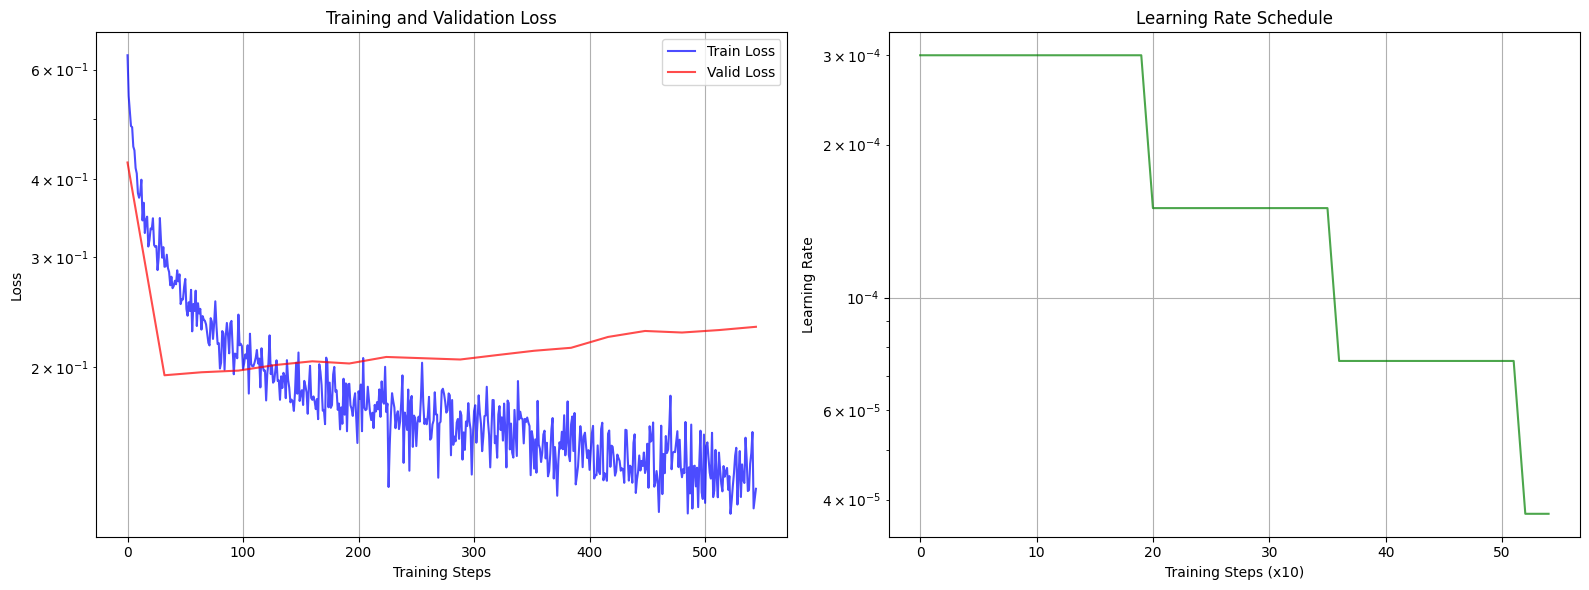


Step 3: Generating predictions for all data splits...
Loading pre-split data...
Creating validation labels from training labels...
Creating test labels from training labels...
Data loaded - Train: 346324, Valid: 74212, Test: 74213
Input dim: 101, Label dim: 8
Label shapes - Train: torch.Size([346324, 8]), Valid: torch.Size([74212, 8]), Test: torch.Size([74213, 8])

Generating predictions for all data splits...
Generating training set predictions...
Training predictions saved to: output/4_1/1sec/train_predictions.npy
Generating validation set predictions...
Validation predictions saved to: output/4_1/1sec/valid_predictions.npy
Generating test set predictions...
Test predictions saved to: output/4_1/1sec/test_predictions.npy
Saving targets for all splits...
Training targets saved to: output/4_1/1sec/train_targets.npy
Validation targets saved to: output/4_1/1sec/valid_targets.npy
Test targets saved to: output/4_1/1sec/test_targets.npy

PREDICTION SUMMARY
Training set: (346324, 8) predict

In [8]:
# Run for 1-second data with enhanced architecture
run_alpha101_training_pipeline(timeframe='1sec', gpu_id=0, use_enhanced=True)

Starting Enhanced Alpha101 Training Pipeline for 1min
Step 1: Generating labels...
Generated labels: (4874, 8)
Labels saved to: data/1min/alpha101/labels.npy

Step 2: Training enhanced sequence model...
Using device: cuda:0
Loading data...
Loading pre-split data...
Creating validation labels from training labels...
Creating test labels from training labels...
Data loaded - Train: 5774, Valid: 1237, Test: 1238
Input dim: 101, Label dim: 8
Label shapes - Train: torch.Size([5774, 8]), Valid: torch.Size([1237, 8]), Test: torch.Size([1238, 8])
Input dim: 101, Label dim: 8
Initializing enhanced model...
Starting training...
Training for 180 steps...
Step 0: Train Loss = 0.529663, LR = 3.00e-04
Step      0 | Train Loss: 0.529663 | Valid Loss: 0.350474 | Patience: 0
Step 10: Train Loss = 0.377522, LR = 3.00e-04
Step 20: Train Loss = 0.290521, LR = 3.00e-04
Step 30: Train Loss = 0.268090, LR = 3.00e-04
Step     32 | Train Loss: 0.274966 | Valid Loss: 0.126682 | Patience: 0
Step 40: Train Loss =

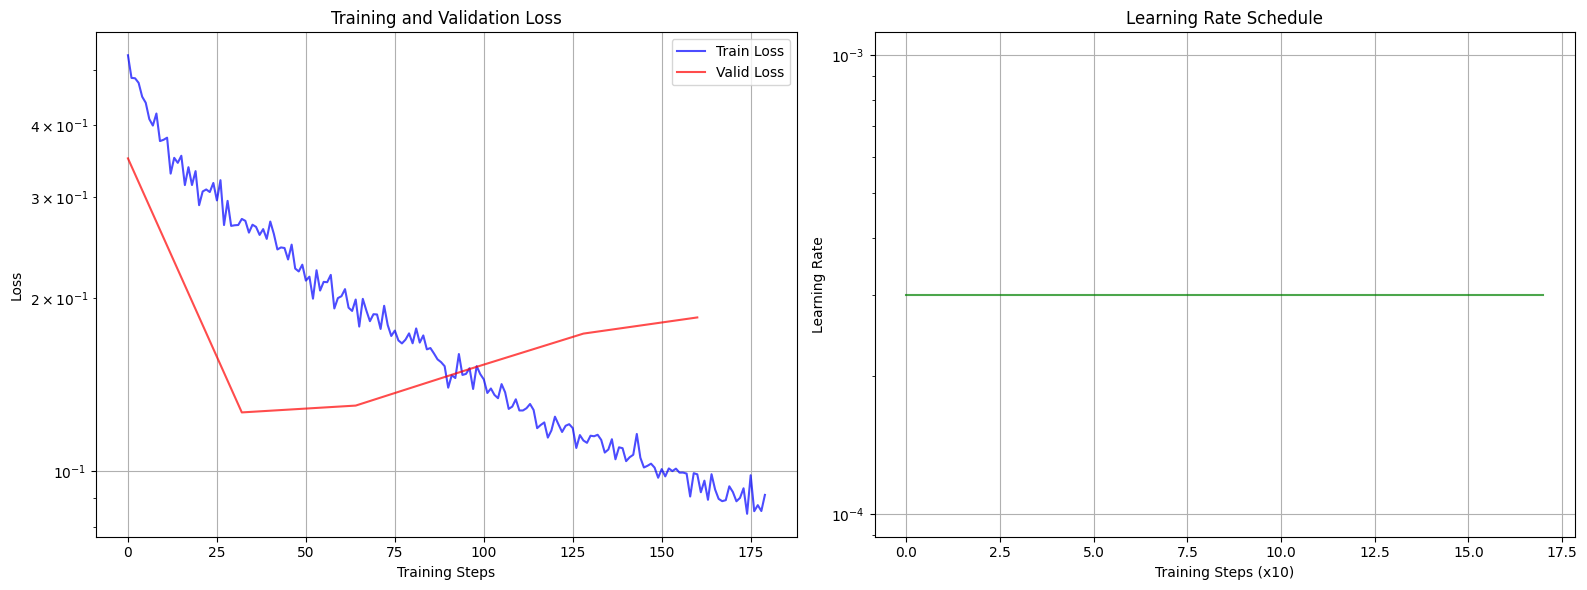


Step 3: Generating predictions for all data splits...
Loading pre-split data...
Creating validation labels from training labels...
Creating test labels from training labels...
Data loaded - Train: 5774, Valid: 1237, Test: 1238
Input dim: 101, Label dim: 8
Label shapes - Train: torch.Size([5774, 8]), Valid: torch.Size([1237, 8]), Test: torch.Size([1238, 8])

Generating predictions for all data splits...
Generating training set predictions...
Training predictions saved to: output/4_1/1min/train_predictions.npy
Generating validation set predictions...
Validation predictions saved to: output/4_1/1min/valid_predictions.npy
Generating test set predictions...
Test predictions saved to: output/4_1/1min/test_predictions.npy
Saving targets for all splits...
Training targets saved to: output/4_1/1min/train_targets.npy
Validation targets saved to: output/4_1/1min/valid_targets.npy
Test targets saved to: output/4_1/1min/test_targets.npy

PREDICTION SUMMARY
Training set: (5774, 8) predictions saved

In [9]:
# Run for 1-minute data with enhanced architecture
run_alpha101_training_pipeline(timeframe='1min', gpu_id=0, use_enhanced=True)